In [4]:
import tensorflow.compat.v1 as tf
import scipy.io
import numpy as np
import os
import random
import math
import pandas as pd
import seaborn as sns
#from skimage.measure import structural_similarity as ssim
#from sporco import util
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import linear_model
from sklearn.linear_model import Lasso
from sklearn.feature_selection import RFECV, RFE
import multiprocessing
import datetime
import hdf5storage

In [2]:
def fnn(x, input_size, output_size, keep_prob, stddev=0.01, constant=0.0001, dropout=True, end=False):
    fc_w = tf.Variable(tf.truncated_normal([input_size,output_size], stddev=stddev,seed=np.random.seed(2018)))
    fc_b = tf.Variable(tf.constant(constant,shape=[output_size]), dtype=tf.float32)
    fc_h = tf.nn.relu(tf.matmul(x,fc_w)+fc_b) if not end else tf.matmul(x,fc_w)+fc_b
    return tf.nn.dropout(fc_h, keep_prob,seed=np.random.seed(2018)) if dropout else fc_h

In [3]:
def fcn(x, input_size, output_size, nlayers, nparameters, keep_prob):
    if nlayers == 1:
        h1 = fnn(x, input_size, output_size, keep_prob, end=True)
    elif nlayers == 2:
        h1 = fnn(fnn(x, input_size, nparameters, keep_prob, end=False), nparameters, output_size, keep_prob, end=True)
    elif nlayers >= 3:
        h0 = fnn(x, input_size, nparameters, keep_prob, end=False)
        for j in range(0,nlayers-2):
            if j == 0:
                h1 = fnn(h0, nparameters, nparameters, keep_prob, end=False)
            else:
                h1 = fnn(h1, nparameters, nparameters, keep_prob, end=False)
        h1 = fnn(h1, nparameters, output_size, keep_prob, end=True)
    else:
        print("# of layers can't be smaller than 0")
    return h1

In [4]:
def rfc(train_data, train_label, test_data, test_label):
    rf = RandomForestClassifier(n_estimators=150,
                                    criterion='gini',
                                    max_depth=None,
                                    min_samples_split=2,
                                    min_samples_leaf=1,
                                    min_weight_fraction_leaf=0.0,
                                    max_features=None,
                                    max_leaf_nodes=None,
                                    bootstrap=True,
                                    oob_score=False,
                                    n_jobs=-1,
                                    random_state=123,
                                    verbose=0,
                                    warm_start=False,
                                    class_weight=None)
    rf.fit(train_data, train_label.ravel())
    result = rf.predict_proba(test_data)
    acc = 0.0
    for i in range(np.shape(test_data)[0]):
        r = np.argmax(result[i])
        if r == test_label[i]:
            acc += 1
    acc /= np.shape(test_data)[0]
    acc *= 100
    return acc, result

In [5]:
def dnn(train_data, train_label, test_data, test_label):
    g = tf.Graph()
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    batch_size = 10
    input_size = np.shape(train_data)[1]
    output_size = 31

    with g.as_default():
        p_x = tf.placeholder(tf.float32, [batch_size, 1, input_size, 1])
        p_y = tf.placeholder(tf.float32, [batch_size, output_size])
        keep_prob = tf.placeholder(tf.float32)
        h10_flat = tf.reshape(p_x, [batch_size,-1])
        h1 = fnn(h10_flat, input_size, 2048, keep_prob, end=False)
        h2 = fnn(h1, 2048, 2048, keep_prob, end=False)
        h3 = fnn(h2, 2048, 31, keep_prob, end=True)
        h4 = tf.reshape(h3, [batch_size, 31])
        h_c = tf.nn.softmax(h4)
        loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(labels=p_y, logits=h4))
        optim = tf.train.AdamOptimizer(1e-5)
        trainer = optim.minimize(loss)
    
    accuracy = 0.0
    result = np.zeros([np.shape(test_data)[0], 31])
    with tf.Session(graph=g, config=config) as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(0,120):
            loss_tot = 0.0
            for i in range(0,int(np.ceil(np.shape(train_data)[0]/batch_size))):
                a = np.random.randint(0,np.shape(train_data)[0],size=batch_size)
                x = train_data[a].reshape([batch_size, 1, input_size, 1])#[4,1,18181,1]
                y = np.zeros([batch_size, output_size])
                index = train_label[a]
                for u in range(0,batch_size):
                    y[u,index[u]] = 1
                _ , loss_val = sess.run([trainer, loss], feed_dict={p_x:x, p_y:y, keep_prob:0.6})
                loss_tot += loss_val
            print("%d epoch Loss: %f" % (e,(loss_tot)/np.shape(train_data)[0]))
        temp = 0
        for i in range(0,int(np.floor(np.shape(test_data)[0]/batch_size))):
            x = test_data[i*batch_size:(i+1)*batch_size].reshape([batch_size, 1, input_size, 1])
            out = sess.run(h_c, feed_dict={p_x:x, keep_prob:1})
            for j in range(0, batch_size):
                t = np.squeeze(out[j])
                result[temp] = t
                temp+=1
        remain = int(np.shape(test_data)[0]-np.floor(np.shape(test_data)[0]/batch_size)*batch_size)
        if remain > 0:
            x = test_data[-batch_size-1:-1].reshape([batch_size, 1, input_size, 1])
            out = sess.run(h_c, feed_dict={p_x:x, keep_prob:1})
            for j in range(0,int(remain)):
                t = np.squeeze(out[j+(batch_size-remain)])
                result[temp] = t
                temp+=1
        for i in range(0,np.shape(test_data)[0]):
            ind = np.argmax(np.squeeze(result[i]))
            if ind == test_label[i]:
                accuracy += 1
        accuracy /= np.shape(test_data)[0]*0.01
        sess.close()
    return accuracy, result

In [6]:
dataID = hdf5storage.loadmat('data.mat')
data = np.array(dataID['data'], dtype=np.float32)
gt1 = scipy.io.loadmat('label.mat')
label = np.array(gt1['label'], dtype=np.int32)

In [7]:
Outer_loop = 10
Inner_loop = 10

In [ ]:
##########################################################################################################################

In [ ]:
#No select

In [8]:
if __name__ == "__main__":
#Load data

    
    #Initialize
    label -= 1
    np.random.seed(2018)


    
    t_index = np.random.permutation(int(np.shape(data)[0]/Outer_loop)*Outer_loop)
    t_index = np.reshape(t_index, [Outer_loop, -1])
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"]="0" 
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    
    box = np.array([4000], dtype=np.int32)
    flag = 0
    for test_index in t_index:
        if flag == Outer_loop-1:
            test_index = np.array(np.concatenate((test_index, np.array(range(int(np.shape(data)[0]/Outer_loop)*Outer_loop,np.shape(data)[0]))), axis=0), dtype=np.int32)
        train_index = np.setdiff1d(np.array(range(0,np.shape(data)[0])), test_index)
        train_data = data[train_index]
        train_label = label[train_index]
        test_data = data[test_index]
        test_label = label[test_index]
        
        kf = np.random.permutation(int(np.shape(train_data)[0]/Inner_loop)*Inner_loop)
        kf = kf.reshape([Inner_loop]+[-1])
        val_result = np.zeros([np.shape(train_data)[0],48], dtype=np.float32)
        
        tot_acc = np.zeros([Inner_loop,5], dtype=np.float32)
        #lasso = Lasso()
        #lsvc = LinearSVC(C=1, penalty="l1", dual=False).fit(data, label)
        #coef = np.squeeze(np.sum(np.square(np.array(lsvc.coef_)), axis=0))
        #coef = np.squeeze(np.sum(np.square(np.array(lasso.coef_)), axis=0))
        #coefidx = np.argsort(coef)
#         for inner_fold in range(0,Inner_loop):
#             val_test_ind = kf[inner_fold]
#             if inner_fold == Inner_loop-1:
#                 val_test_ind = np.array(np.concatenate((val_test_ind,np.array(range(int(np.shape(train_data)[0]/Outer_loop)*Outer_loop,np.shape(train_data)[0]),dtype=np.int32)), axis=0),dtype=np.int32)
            
#             val_train_ind = np.setdiff1d(np.array(range(0,np.shape(train_data)[0]),dtype=np.int32), val_test_ind)
#             val_train = train_data[val_train_ind]
#             val_test = train_data[val_test_ind]
#             val_train_label = train_label[val_train_ind]
#             val_test_label = train_label[val_test_ind]
#             temp = 0
#             for item in box:
#                 idx = coefidx[-item:]
#                 vtrain = val_train[:,idx]
#                 vtest = val_test[:,idx]
#                 nn_acc, result_nn = dnn(vtrain, val_train_label, vtest, val_test_label)
#                 rf_acc, result_rf = rfc(vtrain, val_train_label, vtest, val_test_label)
#                 en_acc = 0.0
#                 for i in range(0,np.shape(vtest)[0]):
#                     r = np.argmax(result_nn[i]+result_rf[i])
#                     if r == val_test_label[i]:
#                         en_acc += 1
#                 en_acc /= np.shape(vtest)[0]*0.01
#                 tot_acc[inner_fold,temp] = en_acc
#                 print("Inner_fold # of features: %d, Neural network accuracy: %f, Random forests accuracy: %f, Ensemble accuracy: %f" % (item, nn_acc, rf_acc, en_acc))
#                 temp += 1
        
        u = np.sum(tot_acc,0)
       
        best_n = box[np.argmax(u)]
#        idx = coefidx[-best_n:]
        
#        tr_data = train_data[:,idx]
#        te_data = test_data[:,idx]
        nn_acc, result_nn = dnn(train_data, train_label, test_data, test_label)
        rf_acc, result_rf = rfc(train_data, train_label, test_data, test_label)
        en_acc = 0.0
        for i in range(0,np.shape(test_data)[0]):
            r = np.argmax(result_nn[i]+result_rf[i])
            if r == test_label[i]:
                en_acc += 1
        en_acc /= np.shape(test_data)[0]*0.01
        print("Outer_fold # of features:  %d, Neural network accuracy: %f, Random forests accuracy: %f, Ensemble accuracy: %f" % (best_n, nn_acc, rf_acc, en_acc))
        flag += 1

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

0 epoch Loss: 3.110789
1 epoch Loss: 2.655721
2 epoch Loss: 2.449468
3 epoch Loss: 2.351386
4 epoch Loss: 2.236539
5 epoch Loss: 2.202395
6 epoch Loss: 2.086961
7 epoch Loss: 2.037218
8 epoch Loss: 1.984925
9 epoch Loss: 1.939601
10 epoch Loss: 1.872381
11 epoch Loss: 1.877065
12 epoch Loss: 1.828764
13 epoch Loss: 1.759474
14 epoch Loss: 1.740209
15 epoch Loss: 1.649005
16 epoch Loss: 1.633552
17 epoch Loss: 1.589401
18 epoch Loss: 1.560510
19 epoch Loss: 1.543371
20 epoch Loss: 1.499568
21 epoch Loss: 1.453408
22 epoch Loss: 1.450271
23 epoch Loss: 1.402040
24 epoch Loss: 1.377945
25 epoch Loss: 1.331619

47 epoch Loss: 1.139266
48 epoch Loss: 1.099404
49 epoch Loss: 1.103059
50 epoch Loss: 1.074333
51 epoch Loss: 1.114221
52 epoch Loss: 1.092705
53 epoch Loss: 1.098148
54 epoch Loss: 1.067369
55 epoch Loss: 1.085901
56 epoch Loss: 1.086450
57 epoch Loss: 1.058019
58 epoch Loss: 1.033146
59 epoch Loss: 1.073377
60 epoch Loss: 1.057879
61 epoch Loss: 1.062973
62 epoch Loss: 1.069221
63 epoch Loss: 1.062959
64 epoch Loss: 1.086612
65 epoch Loss: 1.029951
66 epoch Loss: 1.056532
67 epoch Loss: 1.044552
68 epoch Loss: 1.064686
69 epoch Loss: 1.029901
70 epoch Loss: 1.054319
71 epoch Loss: 1.051597
72 epoch Loss: 1.045254
73 epoch Loss: 1.050666
74 epoch Loss: 1.060179
75 epoch Loss: 1.031216
76 epoch Loss: 1.066315
77 epoch Loss: 1.073136
78 epoch Loss: 1.058837
79 epoch Loss: 1.022108
80 epoch Loss: 1.021134
81 epoch Loss: 1.033943
82 epoch Loss: 1.062733
83 epoch Loss: 1.032640
84 epoch Loss: 1.039889
85 epoch Loss: 1.039289
86 epoch Loss: 1.036772
87 epoch Loss: 1.043366
88 epoch Loss: 1

11 epoch Loss: 1.852383
12 epoch Loss: 1.805297
13 epoch Loss: 1.761635
14 epoch Loss: 1.719393
15 epoch Loss: 1.680133
16 epoch Loss: 1.643024
17 epoch Loss: 1.613421
18 epoch Loss: 1.563152
19 epoch Loss: 1.517663
20 epoch Loss: 1.485067
21 epoch Loss: 1.506374
22 epoch Loss: 1.424089
23 epoch Loss: 1.405121
24 epoch Loss: 1.373335
25 epoch Loss: 1.370389
26 epoch Loss: 1.339172
27 epoch Loss: 1.317954
28 epoch Loss: 1.321470
29 epoch Loss: 1.267472
30 epoch Loss: 1.305418
31 epoch Loss: 1.280021
32 epoch Loss: 1.249059
33 epoch Loss: 1.189250
34 epoch Loss: 1.195233
35 epoch Loss: 1.198614
36 epoch Loss: 1.206030
37 epoch Loss: 1.178925
38 epoch Loss: 1.164223
39 epoch Loss: 1.184287
40 epoch Loss: 1.151603
41 epoch Loss: 1.126793
42 epoch Loss: 1.134464
43 epoch Loss: 1.149514
44 epoch Loss: 1.120582
45 epoch Loss: 1.105401
46 epoch Loss: 1.102811
47 epoch Loss: 1.084885
48 epoch Loss: 1.108272
49 epoch Loss: 1.104902
50 epoch Loss: 1.106782
51 epoch Loss: 1.113303
52 epoch Loss: 1

101 epoch Loss: 1.026934
102 epoch Loss: 1.033193
103 epoch Loss: 1.021565
104 epoch Loss: 1.050575
105 epoch Loss: 1.021151
106 epoch Loss: 1.032406
107 epoch Loss: 1.030612
108 epoch Loss: 1.038260
109 epoch Loss: 1.013158
110 epoch Loss: 1.040054
111 epoch Loss: 0.986673
112 epoch Loss: 1.015466
113 epoch Loss: 1.024130
114 epoch Loss: 1.028192
115 epoch Loss: 1.039162
116 epoch Loss: 1.027259
117 epoch Loss: 1.022991
118 epoch Loss: 1.044685
119 epoch Loss: 0.991400
Outer_fold # of features:  4000, Neural network accuracy: 79.142857, Random forests accuracy: 76.142857, Ensemble accuracy: 80.000000
0 epoch Loss: 3.092706
1 epoch Loss: 2.674574
2 epoch Loss: 2.473862
3 epoch Loss: 2.312465
4 epoch Loss: 2.229769
5 epoch Loss: 2.144419
6 epoch Loss: 2.096243
7 epoch Loss: 2.049141
8 epoch Loss: 1.992454
9 epoch Loss: 1.941604
10 epoch Loss: 1.909385
11 epoch Loss: 1.875473
12 epoch Loss: 1.815857
13 epoch Loss: 1.767686
14 epoch Loss: 1.717684
15 epoch Loss: 1.693780
16 epoch Loss: 1.

In [ ]:
# NN_35565=[75.555556,74.761905,78.730159,80.158730,77.301587,74.920635,78.095238,78.571429,76.984127,75.316456]
# RF_35565=[70.634921,72.222222,73.333333,74.761905,73.492063,73.174603,73.333333,71.904762,73.809524,72.468354]
# emsemble_35565=[77.619048,78.571429,82.222222,82.539683,81.269841,77.301587,79.206349,80.793651,79.047619,77.848101]

In [ ]:
data = {'Accuracy':acc,'Model':md}

In [ ]:
df = pd.DataFrame(data) 
df

In [ ]:
sns.set(style="whitegrid",rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x = "Model", y = "Accuracy", data = df, palette="Set3", width=0.6, fliersize=2)
#ax.set_xticklabels(ax.get_xticklabels(),rotation=10)

In [ ]:
##########################################################################################################################

In [ ]:
#LSVC

In [46]:
if __name__ == "__main__":
#Load data

    
    #Initialize
    label -= 1
    np.random.seed(2018)


    
    t_index = np.random.permutation(int(np.shape(data)[0]/Outer_loop)*Outer_loop)
    t_index = np.reshape(t_index, [Outer_loop, -1])
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"]="0" 
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    
    box = np.array([4000], dtype=np.int32)
    flag = 0
    for test_index in t_index:
        if flag == Outer_loop-1:
            test_index = np.array(np.concatenate((test_index, np.array(range(int(np.shape(data)[0]/Outer_loop)*Outer_loop,np.shape(data)[0]))), axis=0), dtype=np.int32)
        train_index = np.setdiff1d(np.array(range(0,np.shape(data)[0])), test_index)
        train_data = data[train_index]
        train_label = label[train_index]
        test_data = data[test_index]
        test_label = label[test_index]
        
        kf = np.random.permutation(int(np.shape(train_data)[0]/Inner_loop)*Inner_loop)
        kf = kf.reshape([Inner_loop]+[-1])
        val_result = np.zeros([np.shape(train_data)[0],48], dtype=np.float32)
        
        tot_acc = np.zeros([Inner_loop,5], dtype=np.float32)
        #lasso = Lasso()
        lsvc = LinearSVC(C=1, penalty="l1", dual=False).fit(data, label)
        coef = np.squeeze(np.sum(np.square(np.array(lsvc.coef_)), axis=0))
        #coef = np.squeeze(np.sum(np.square(np.array(lasso.coef_)), axis=0))
        coefidx = np.argsort(coef)
#         for inner_fold in range(0,Inner_loop):
#             val_test_ind = kf[inner_fold]
#             if inner_fold == Inner_loop-1:
#                 val_test_ind = np.array(np.concatenate((val_test_ind,np.array(range(int(np.shape(train_data)[0]/Outer_loop)*Outer_loop,np.shape(train_data)[0]),dtype=np.int32)), axis=0),dtype=np.int32)
            
#             val_train_ind = np.setdiff1d(np.array(range(0,np.shape(train_data)[0]),dtype=np.int32), val_test_ind)
#             val_train = train_data[val_train_ind]
#             val_test = train_data[val_test_ind]
#             val_train_label = train_label[val_train_ind]
#             val_test_label = train_label[val_test_ind]
#             temp = 0
#             for item in box:
#                 idx = coefidx[-item:]
#                 vtrain = val_train[:,idx]
#                 vtest = val_test[:,idx]
#                 nn_acc, result_nn = dnn(vtrain, val_train_label, vtest, val_test_label)
#                 rf_acc, result_rf = rfc(vtrain, val_train_label, vtest, val_test_label)
#                 en_acc = 0.0
#                 for i in range(0,np.shape(vtest)[0]):
#                     r = np.argmax(result_nn[i]+result_rf[i])
#                     if r == val_test_label[i]:
#                         en_acc += 1
#                 en_acc /= np.shape(vtest)[0]*0.01
#                 tot_acc[inner_fold,temp] = en_acc
#                 print("Inner_fold # of features: %d, Neural network accuracy: %f, Random forests accuracy: %f, Ensemble accuracy: %f" % (item, nn_acc, rf_acc, en_acc))
#                 temp += 1
        
        u = np.sum(tot_acc,0)
        
       
        best_n = box[np.argmax(u)]
        idx = coefidx[-best_n:]
        
        tr_data = train_data[:,idx]
        te_data = test_data[:,idx]
        nn_acc, result_nn = dnn(tr_data, train_label, te_data, test_label)
        rf_acc, result_rf = rfc(tr_data, train_label, te_data, test_label)
        en_acc = 0.0
        for i in range(0,np.shape(te_data)[0]):
            r = np.argmax(result_nn[i]+result_rf[i])
            if r == test_label[i]:
                en_acc += 1
        en_acc /= np.shape(te_data)[0]*0.01
        print("Outer_fold # of features:  %d, Neural network accuracy: %f, Random forests accuracy: %f, Ensemble accuracy: %f" % (best_n, nn_acc, rf_acc, en_acc))
        flag += 1

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.310719
1 epoch Loss: 3.057256
2 epoch Loss: 2.842020
3 epoch Loss: 2.679981
4 epoch Loss: 2.518098
5 epoch Loss: 2.460461
6 epoch Loss: 2.322171
7 epoch Loss: 2.276983
8 epoch Loss: 2.190795
9 epoch Loss: 2.159150
10 epoch Loss: 2.060299
11 epoch Loss: 2.058204
12 epoch Loss: 1.976052
13 epoch Loss: 1.913965
14 epoch Loss: 1.945198
15 epoch Loss: 1.869561
16 epoch Loss: 1.817971
17 epoch Loss: 1.792062
18 epoch Loss: 1.741372
19 epoch Loss: 1.715327
20 epoch Loss: 1.644492
21 epoch Loss: 1.659347
22 epoch Loss: 1.634921
23 epoch Loss: 1.588886
24 epoch Loss: 1.562715
25 epoch Loss: 1.513573
26 epoch Loss: 1.511111
27 epoch Loss: 1.493179
28 epoch Loss: 1.429190
29 epoch Loss: 1.448614
30 epoch Loss: 1.452646
31 epoch Loss: 1.440261
32 epoch Loss: 1.381558
33 epoch Loss: 1.366764
34 epoch Loss: 1.337785
35 epoch Loss: 1.370940
36 epoch Loss: 1.320124
37 epoch Loss: 1.287493
38 epoch Loss: 1.285838
39 epoch Loss: 1.245378
40 epoch Loss: 1.262948
41 epoch Loss: 1.283731
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.299424
1 epoch Loss: 3.062167
2 epoch Loss: 2.857814
3 epoch Loss: 2.650655
4 epoch Loss: 2.540277
5 epoch Loss: 2.444268
6 epoch Loss: 2.340232
7 epoch Loss: 2.267813
8 epoch Loss: 2.188918
9 epoch Loss: 2.155684
10 epoch Loss: 2.089480
11 epoch Loss: 2.062339
12 epoch Loss: 1.999219
13 epoch Loss: 1.939038
14 epoch Loss: 1.901223
15 epoch Loss: 1.860395
16 epoch Loss: 1.841956
17 epoch Loss: 1.780767
18 epoch Loss: 1.705276
19 epoch Loss: 1.711139
20 epoch Loss: 1.688436
21 epoch Loss: 1.646381
22 epoch Loss: 1.650312
23 epoch Loss: 1.571922
24 epoch Loss: 1.568630
25 epoch Loss: 1.517843
26 epoch Loss: 1.508607
27 epoch Loss: 1.508571
28 epoch Loss: 1.467395
29 epoch Loss: 1.452396
30 epoch Loss: 1.428513
31 epoch Loss: 1.398368
32 epoch Loss: 1.412186
33 epoch Loss: 1.383392
34 epoch Loss: 1.355056
35 epoch Loss: 1.364988
36 epoch Loss: 1.352904
37 epoch Loss: 1.358970
38 epoch Loss: 1.288204
39 epoch Loss: 1.300534
40 epoch Loss: 1.305390
41 epoch Loss: 1.290972
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.305181
1 epoch Loss: 3.081078
2 epoch Loss: 2.849780
3 epoch Loss: 2.662886
4 epoch Loss: 2.540391
5 epoch Loss: 2.439088
6 epoch Loss: 2.358856
7 epoch Loss: 2.268872
8 epoch Loss: 2.217098
9 epoch Loss: 2.169975
10 epoch Loss: 2.081108
11 epoch Loss: 2.049602
12 epoch Loss: 1.992225
13 epoch Loss: 1.904408
14 epoch Loss: 1.933161
15 epoch Loss: 1.859438
16 epoch Loss: 1.831039
17 epoch Loss: 1.763823
18 epoch Loss: 1.727908
19 epoch Loss: 1.711636
20 epoch Loss: 1.672765
21 epoch Loss: 1.633638
22 epoch Loss: 1.654721
23 epoch Loss: 1.592889
24 epoch Loss: 1.596395
25 epoch Loss: 1.524454
26 epoch Loss: 1.517944
27 epoch Loss: 1.512854
28 epoch Loss: 1.453163
29 epoch Loss: 1.444536
30 epoch Loss: 1.436003
31 epoch Loss: 1.416157
32 epoch Loss: 1.402117
33 epoch Loss: 1.407093
34 epoch Loss: 1.373454
35 epoch Loss: 1.340259
36 epoch Loss: 1.356929
37 epoch Loss: 1.327682
38 epoch Loss: 1.310913
39 epoch Loss: 1.283607
40 epoch Loss: 1.289683
41 epoch Loss: 1.262390
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.301729
1 epoch Loss: 3.059731
2 epoch Loss: 2.848877
3 epoch Loss: 2.654081
4 epoch Loss: 2.549233
5 epoch Loss: 2.483818
6 epoch Loss: 2.353323
7 epoch Loss: 2.292512
8 epoch Loss: 2.209664
9 epoch Loss: 2.138418
10 epoch Loss: 2.078721
11 epoch Loss: 2.068344
12 epoch Loss: 2.023943
13 epoch Loss: 1.936435
14 epoch Loss: 1.906122
15 epoch Loss: 1.845803
16 epoch Loss: 1.815241
17 epoch Loss: 1.777111
18 epoch Loss: 1.759096
19 epoch Loss: 1.731192
20 epoch Loss: 1.697060
21 epoch Loss: 1.658665
22 epoch Loss: 1.606579
23 epoch Loss: 1.589828
24 epoch Loss: 1.565210
25 epoch Loss: 1.560665
26 epoch Loss: 1.524722
27 epoch Loss: 1.502273
28 epoch Loss: 1.487242
29 epoch Loss: 1.480385
30 epoch Loss: 1.434890
31 epoch Loss: 1.430096
32 epoch Loss: 1.399053
33 epoch Loss: 1.408993
34 epoch Loss: 1.365594
35 epoch Loss: 1.320412
36 epoch Loss: 1.346560
37 epoch Loss: 1.314339
38 epoch Loss: 1.259795
39 epoch Loss: 1.289956
40 epoch Loss: 1.299226
41 epoch Loss: 1.286077
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.301092
1 epoch Loss: 3.058680
2 epoch Loss: 2.859800
3 epoch Loss: 2.686576
4 epoch Loss: 2.514249
5 epoch Loss: 2.459444
6 epoch Loss: 2.341753
7 epoch Loss: 2.273892
8 epoch Loss: 2.217465
9 epoch Loss: 2.150462
10 epoch Loss: 2.086863
11 epoch Loss: 2.086723
12 epoch Loss: 1.993728
13 epoch Loss: 1.957869
14 epoch Loss: 1.912502
15 epoch Loss: 1.838401
16 epoch Loss: 1.824266
17 epoch Loss: 1.812723
18 epoch Loss: 1.733134
19 epoch Loss: 1.707964
20 epoch Loss: 1.682826
21 epoch Loss: 1.648313
22 epoch Loss: 1.642080
23 epoch Loss: 1.629427
24 epoch Loss: 1.595382
25 epoch Loss: 1.543376
26 epoch Loss: 1.519906
27 epoch Loss: 1.549699
28 epoch Loss: 1.495097
29 epoch Loss: 1.459153
30 epoch Loss: 1.406699
31 epoch Loss: 1.398858
32 epoch Loss: 1.415119
33 epoch Loss: 1.374470
34 epoch Loss: 1.375785
35 epoch Loss: 1.346347
36 epoch Loss: 1.362413
37 epoch Loss: 1.332418
38 epoch Loss: 1.323151
39 epoch Loss: 1.306538
40 epoch Loss: 1.271507
41 epoch Loss: 1.291846
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.307845
1 epoch Loss: 3.054070
2 epoch Loss: 2.835854
3 epoch Loss: 2.650138
4 epoch Loss: 2.535246
5 epoch Loss: 2.442703
6 epoch Loss: 2.353704
7 epoch Loss: 2.271527
8 epoch Loss: 2.208033
9 epoch Loss: 2.165883
10 epoch Loss: 2.073394
11 epoch Loss: 2.054374
12 epoch Loss: 2.005544
13 epoch Loss: 1.945898
14 epoch Loss: 1.901107
15 epoch Loss: 1.818436
16 epoch Loss: 1.808882
17 epoch Loss: 1.776940
18 epoch Loss: 1.732081
19 epoch Loss: 1.682647
20 epoch Loss: 1.645586
21 epoch Loss: 1.682561
22 epoch Loss: 1.654741
23 epoch Loss: 1.580241
24 epoch Loss: 1.557944
25 epoch Loss: 1.548242
26 epoch Loss: 1.545306
27 epoch Loss: 1.498853
28 epoch Loss: 1.532131
29 epoch Loss: 1.455982
30 epoch Loss: 1.445089
31 epoch Loss: 1.423340
32 epoch Loss: 1.390380
33 epoch Loss: 1.388738
34 epoch Loss: 1.383643
35 epoch Loss: 1.382539
36 epoch Loss: 1.299300
37 epoch Loss: 1.305229
38 epoch Loss: 1.298715
39 epoch Loss: 1.296716
40 epoch Loss: 1.286751
41 epoch Loss: 1.266280
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.298809
1 epoch Loss: 3.040163
2 epoch Loss: 2.835002
3 epoch Loss: 2.664063
4 epoch Loss: 2.528808
5 epoch Loss: 2.424531
6 epoch Loss: 2.333202
7 epoch Loss: 2.256436
8 epoch Loss: 2.184590
9 epoch Loss: 2.146077
10 epoch Loss: 2.061520
11 epoch Loss: 2.028784
12 epoch Loss: 1.977339
13 epoch Loss: 1.924852
14 epoch Loss: 1.863451
15 epoch Loss: 1.819715
16 epoch Loss: 1.825741
17 epoch Loss: 1.780716
18 epoch Loss: 1.731833
19 epoch Loss: 1.723984
20 epoch Loss: 1.664620
21 epoch Loss: 1.640637
22 epoch Loss: 1.609938
23 epoch Loss: 1.579983
24 epoch Loss: 1.556351
25 epoch Loss: 1.547389
26 epoch Loss: 1.530760
27 epoch Loss: 1.520958
28 epoch Loss: 1.472584
29 epoch Loss: 1.453415
30 epoch Loss: 1.417488
31 epoch Loss: 1.411611
32 epoch Loss: 1.395660
33 epoch Loss: 1.400935
34 epoch Loss: 1.349908
35 epoch Loss: 1.370995
36 epoch Loss: 1.319143
37 epoch Loss: 1.334801
38 epoch Loss: 1.290439
39 epoch Loss: 1.301644
40 epoch Loss: 1.265542
41 epoch Loss: 1.252707
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.308000
1 epoch Loss: 3.080876
2 epoch Loss: 2.867749
3 epoch Loss: 2.677594
4 epoch Loss: 2.530935
5 epoch Loss: 2.450881
6 epoch Loss: 2.362715
7 epoch Loss: 2.275850
8 epoch Loss: 2.211630
9 epoch Loss: 2.129360
10 epoch Loss: 2.106263
11 epoch Loss: 2.081056
12 epoch Loss: 1.996155
13 epoch Loss: 1.952961
14 epoch Loss: 1.925194
15 epoch Loss: 1.845612
16 epoch Loss: 1.832429
17 epoch Loss: 1.803304
18 epoch Loss: 1.770312
19 epoch Loss: 1.709246
20 epoch Loss: 1.708583
21 epoch Loss: 1.653558
22 epoch Loss: 1.624647
23 epoch Loss: 1.623245
24 epoch Loss: 1.568527
25 epoch Loss: 1.570508
26 epoch Loss: 1.545486
27 epoch Loss: 1.482163
28 epoch Loss: 1.468230
29 epoch Loss: 1.464309
30 epoch Loss: 1.430926
31 epoch Loss: 1.415331
32 epoch Loss: 1.397830
33 epoch Loss: 1.377975
34 epoch Loss: 1.364017
35 epoch Loss: 1.358585
36 epoch Loss: 1.336527
37 epoch Loss: 1.323112
38 epoch Loss: 1.315572
39 epoch Loss: 1.320150
40 epoch Loss: 1.274896
41 epoch Loss: 1.296631
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.294894
1 epoch Loss: 3.069373
2 epoch Loss: 2.840021
3 epoch Loss: 2.649222
4 epoch Loss: 2.512878
5 epoch Loss: 2.402183
6 epoch Loss: 2.329227
7 epoch Loss: 2.272336
8 epoch Loss: 2.164235
9 epoch Loss: 2.132589
10 epoch Loss: 2.092755
11 epoch Loss: 2.045479
12 epoch Loss: 1.952923
13 epoch Loss: 1.921551
14 epoch Loss: 1.882305
15 epoch Loss: 1.859456
16 epoch Loss: 1.794275
17 epoch Loss: 1.753563
18 epoch Loss: 1.725567
19 epoch Loss: 1.699327
20 epoch Loss: 1.671585
21 epoch Loss: 1.661360
22 epoch Loss: 1.653817
23 epoch Loss: 1.558971
24 epoch Loss: 1.575794
25 epoch Loss: 1.533352
26 epoch Loss: 1.538994
27 epoch Loss: 1.517411
28 epoch Loss: 1.485650
29 epoch Loss: 1.469154
30 epoch Loss: 1.435509
31 epoch Loss: 1.415296
32 epoch Loss: 1.404718
33 epoch Loss: 1.375201
34 epoch Loss: 1.343894
35 epoch Loss: 1.360041
36 epoch Loss: 1.328593
37 epoch Loss: 1.366391
38 epoch Loss: 1.297215
39 epoch Loss: 1.275376
40 epoch Loss: 1.250461
41 epoch Loss: 1.256404
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:73: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0 epoch Loss: 3.297373
1 epoch Loss: 3.050640
2 epoch Loss: 2.848047
3 epoch Loss: 2.635403
4 epoch Loss: 2.525977
5 epoch Loss: 2.430155
6 epoch Loss: 2.329258
7 epoch Loss: 2.283524
8 epoch Loss: 2.181920
9 epoch Loss: 2.131340
10 epoch Loss: 2.095892
11 epoch Loss: 2.051627
12 epoch Loss: 2.002188
13 epoch Loss: 1.942599
14 epoch Loss: 1.904583
15 epoch Loss: 1.853690
16 epoch Loss: 1.817147
17 epoch Loss: 1.779894
18 epoch Loss: 1.751384
19 epoch Loss: 1.724274
20 epoch Loss: 1.677838
21 epoch Loss: 1.650767
22 epoch Loss: 1.623405
23 epoch Loss: 1.639282
24 epoch Loss: 1.583941
25 epoch Loss: 1.538738
26 epoch Loss: 1.524196
27 epoch Loss: 1.500958
28 epoch Loss: 1.494360
29 epoch Loss: 1.431478
30 epoch Loss: 1.432782
31 epoch Loss: 1.406144
32 epoch Loss: 1.370996
33 epoch Loss: 1.371501
34 epoch Loss: 1.377447
35 epoch Loss: 1.334923
36 epoch Loss: 1.344533
37 epoch Loss: 1.337732
38 epoch Loss: 1.323594
39 epoch Loss: 1.302269
40 epoch Loss: 1.247225
41 epoch Loss: 1.256811
42

In [ ]:
#4000
#lsvc
lsvc_nn=[84.142857,84.428571,83.285714,84.000000,85.571429,86.000000,85.000000,86.428571,85.000000,84.615385]
lsvc_rf=[74.857143,74.857143,73.285714,72.285714,73.857143,72.857143,72.714286,75.714286,74.000000,72.507123]
emsemble=[85.714286,86.714286,85.571429,85.000000,86.857143,86.857143,86.428571,88.285714,86.428571,85.612536]

In [ ]:
acc=[85.714286,86.714286,85.571429,85.000000,86.857143,86.857143,86.428571,88.285714,86.428571,85.612536,
    84.142857,84.428571,83.285714,84.000000,85.571429,86.000000,85.000000,86.428571,85.000000,84.615385,
    74.857143,74.857143,73.285714,72.285714,73.857143,72.857143,72.714286,75.714286,74.000000,72.507123]
md=['ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble',
    'neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network',
    'random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest',
    'ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble']

In [ ]:
data = {'Accuracy':acc,'Model':md}

In [ ]:
sns.set(style="whitegrid",rc={'figure.figsize':(11.7,8.27)})
ax = sns.boxplot(x = "Feature", y = "Accuracy", data = df, palette="Set3", width=0.6, fliersize=2)
ax.set_xticklabels(ax.get_xticklabels(),rotation=10)

In [ ]:
##########################################################################################################################

In [ ]:
#LASSO

In [24]:
if __name__ == "__main__":
#Load data

    
    #Initialize
    label -= 1
  


    
    t_index = np.random.permutation(int(np.shape(data)[0]/Outer_loop)*Outer_loop)
    t_index = np.reshape(t_index, [Outer_loop, -1])
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"]="0" 
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    
    box = np.array([4000], dtype=np.int32)
    flag = 0
    for test_index in t_index:
        if flag == Outer_loop-1:
            test_index = np.array(np.concatenate((test_index, np.array(range(int(np.shape(data)[0]/Outer_loop)*Outer_loop,np.shape(data)[0]))), axis=0), dtype=np.int32)
        train_index = np.setdiff1d(np.array(range(0,np.shape(data)[0])), test_index)
        train_data = data[train_index]
        train_label = label[train_index]
        test_data = data[test_index]
        test_label = label[test_index]
        
        kf = np.random.permutation(int(np.shape(train_data)[0]/Inner_loop)*Inner_loop)
        kf = kf.reshape([Inner_loop]+[-1])
        val_result = np.zeros([np.shape(train_data)[0],48], dtype=np.float32)
        
        tot_acc = np.zeros([Inner_loop,5], dtype=np.float32)
        lasso = Lasso(alpha=0.0003).fit(data, label)#alpha=0.025
        #lsvc = LinearSVC(C=1, penalty="l1", dual=False).fit(data, label)
        #coef = np.squeeze(np.sum(np.square(np.array(lsvc.coef_)), axis=0))
        coef = lasso.coef_
        coefidx = np.argsort(coef)
        # for inner_fold in range(0,Inner_loop):
        #     val_test_ind = kf[inner_fold]
        #     if inner_fold == Inner_loop-1:
        #         val_test_ind = np.array(np.concatenate((val_test_ind,np.array(range(int(np.shape(train_data)[0]/Outer_loop)*Outer_loop,np.shape(train_data)[0]),dtype=np.int32)), axis=0),dtype=np.int32)
            
        #     val_train_ind = np.setdiff1d(np.array(range(0,np.shape(train_data)[0]),dtype=np.int32), val_test_ind)
        #     val_train = train_data[val_train_ind]
        #     val_test = train_data[val_test_ind]
        #     val_train_label = train_label[val_train_ind]
        #     val_test_label = train_label[val_test_ind]
        #     temp = 0
        #     for item in box:
        #         idx = coefidx[-item:]
        #         vtrain = val_train[:,idx]
        #         vtest = val_test[:,idx]
        #         nn_acc, result_nn = dnn(vtrain, val_train_label, vtest, val_test_label)
        #         rf_acc, result_rf = rfc(vtrain, val_train_label, vtest, val_test_label)
        #         en_acc = 0.0
        #         for i in range(0,np.shape(vtest)[0]):
        #             r = np.argmax(result_nn[i]+result_rf[i])
        #             if r == val_test_label[i]:
        #                 en_acc += 1
        #         en_acc /= np.shape(vtest)[0]*0.01
        #         tot_acc[inner_fold,temp] = en_acc
        #         print("Inner_fold # of features: %d, Neural network accuracy: %f, Random forests accuracy: %f, Ensemble accuracy: %f" % (item, nn_acc, rf_acc, en_acc))
        #         temp += 1
        
        u = np.sum(tot_acc,0)
       
        best_n = box[np.argmax(u)]
        idx = coefidx[-best_n:]
        
        tr_data = train_data[:,idx]
        te_data = test_data[:,idx]
        nn_acc, result_nn = dnn(tr_data, train_label, te_data, test_label)
        rf_acc, result_rf = rfc(tr_data, train_label, te_data, test_label)
        #print(rf_acc)
        en_acc = 0.0
        for i in range(0,np.shape(te_data)[0]):
            r = np.argmax(result_nn[i]+result_rf[i])
            if r == test_label[i]:
                en_acc += 1
        en_acc /= np.shape(te_data)[0]*0.01
        print("Outer_fold # of features:  %d, Neural network accuracy: %f, Random forests accuracy: %f, Ensemble accuracy: %f" % (best_n, nn_acc, rf_acc, en_acc))
        flag += 1

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)


0 epoch Loss: 3.328352
1 epoch Loss: 3.091696
2 epoch Loss: 2.892011
3 epoch Loss: 2.714771
4 epoch Loss: 2.595865
5 epoch Loss: 2.491039
6 epoch Loss: 2.415102
7 epoch Loss: 2.364929
8 epoch Loss: 2.271390
9 epoch Loss: 2.231964
10 epoch Loss: 2.144355
11 epoch Loss: 2.146807
12 epoch Loss: 2.100693
13 epoch Loss: 2.032084
14 epoch Loss: 1.994187
15 epoch Loss: 1.933573
16 epoch Loss: 1.957393
17 epoch Loss: 1.925466
18 epoch Loss: 1.874803
19 epoch Loss: 1.872542
20 epoch Loss: 1.834398
21 epoch Loss: 1.792615
22 epoch Loss: 1.790511
23 epoch Loss: 1.726637
24 epoch Loss: 1.727633
25 epoch Loss: 1.724254
26 epoch Loss: 1.693733
27 epoch Loss: 1.685006
28 epoch Loss: 1.644278
29 epoch Loss: 1.636811
30 epoch Loss: 1.613416
31 epoch Loss: 1.574634
32 epoch Loss: 1.564381
33 epoch Loss: 1.559504
34 epoch Loss: 1.519413
35 epoch Loss: 1.521092
36 epoch Loss: 1.512551
37 epoch Loss: 1.433730
38 epoch Loss: 1.456333
39 epoch Loss: 1.440824
40 epoch Loss: 1.432900
41 epoch Loss: 1.416477
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)


0 epoch Loss: 3.319101
1 epoch Loss: 3.080239
2 epoch Loss: 2.907012
3 epoch Loss: 2.711665
4 epoch Loss: 2.595171
5 epoch Loss: 2.525228
6 epoch Loss: 2.439899
7 epoch Loss: 2.368657
8 epoch Loss: 2.288194
9 epoch Loss: 2.260146
10 epoch Loss: 2.181027
11 epoch Loss: 2.150870
12 epoch Loss: 2.088216
13 epoch Loss: 2.055209
14 epoch Loss: 2.030825
15 epoch Loss: 1.973708
16 epoch Loss: 1.949729
17 epoch Loss: 1.940446
18 epoch Loss: 1.875314
19 epoch Loss: 1.857782
20 epoch Loss: 1.838844
21 epoch Loss: 1.793145
22 epoch Loss: 1.768490
23 epoch Loss: 1.745430
24 epoch Loss: 1.772377
25 epoch Loss: 1.732225
26 epoch Loss: 1.673078
27 epoch Loss: 1.697351
28 epoch Loss: 1.635360
29 epoch Loss: 1.610352
30 epoch Loss: 1.607478
31 epoch Loss: 1.607445
32 epoch Loss: 1.609931
33 epoch Loss: 1.555532
34 epoch Loss: 1.516537
35 epoch Loss: 1.542679
36 epoch Loss: 1.499804
37 epoch Loss: 1.507728
38 epoch Loss: 1.489653
39 epoch Loss: 1.472124
40 epoch Loss: 1.452651
41 epoch Loss: 1.407843
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)


0 epoch Loss: 3.330684
1 epoch Loss: 3.098176
2 epoch Loss: 2.901483
3 epoch Loss: 2.736322
4 epoch Loss: 2.608670
5 epoch Loss: 2.501938
6 epoch Loss: 2.413657
7 epoch Loss: 2.372069
8 epoch Loss: 2.291968
9 epoch Loss: 2.251850
10 epoch Loss: 2.217970
11 epoch Loss: 2.180146
12 epoch Loss: 2.101232
13 epoch Loss: 2.056569
14 epoch Loss: 2.049433
15 epoch Loss: 1.969337
16 epoch Loss: 1.979553
17 epoch Loss: 1.926075
18 epoch Loss: 1.900314
19 epoch Loss: 1.841048
20 epoch Loss: 1.836024
21 epoch Loss: 1.795052
22 epoch Loss: 1.810438
23 epoch Loss: 1.758356
24 epoch Loss: 1.702030
25 epoch Loss: 1.726604
26 epoch Loss: 1.696688
27 epoch Loss: 1.658168
28 epoch Loss: 1.657789
29 epoch Loss: 1.610607
30 epoch Loss: 1.604543
31 epoch Loss: 1.597301
32 epoch Loss: 1.590726
33 epoch Loss: 1.523730
34 epoch Loss: 1.543259
35 epoch Loss: 1.495998
36 epoch Loss: 1.499728
37 epoch Loss: 1.459510
38 epoch Loss: 1.470810
39 epoch Loss: 1.457613
40 epoch Loss: 1.454880
41 epoch Loss: 1.413947
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)


0 epoch Loss: 3.327225
1 epoch Loss: 3.111440
2 epoch Loss: 2.888025
3 epoch Loss: 2.725336
4 epoch Loss: 2.596049
5 epoch Loss: 2.489345
6 epoch Loss: 2.413524
7 epoch Loss: 2.356347
8 epoch Loss: 2.318730
9 epoch Loss: 2.242003
10 epoch Loss: 2.206078
11 epoch Loss: 2.176392
12 epoch Loss: 2.114279
13 epoch Loss: 2.069784
14 epoch Loss: 2.028475
15 epoch Loss: 1.991411
16 epoch Loss: 1.979449
17 epoch Loss: 1.897753
18 epoch Loss: 1.914185
19 epoch Loss: 1.837246
20 epoch Loss: 1.868345
21 epoch Loss: 1.833829
22 epoch Loss: 1.802777
23 epoch Loss: 1.756313
24 epoch Loss: 1.738077
25 epoch Loss: 1.750014
26 epoch Loss: 1.717720
27 epoch Loss: 1.705673
28 epoch Loss: 1.641755
29 epoch Loss: 1.629741
30 epoch Loss: 1.600789
31 epoch Loss: 1.589193
32 epoch Loss: 1.561939
33 epoch Loss: 1.572818
34 epoch Loss: 1.537019
35 epoch Loss: 1.531280
36 epoch Loss: 1.510215
37 epoch Loss: 1.478682
38 epoch Loss: 1.498397
39 epoch Loss: 1.455018
40 epoch Loss: 1.443638
41 epoch Loss: 1.444983
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)


0 epoch Loss: 3.330170
1 epoch Loss: 3.073026
2 epoch Loss: 2.891737
3 epoch Loss: 2.720230
4 epoch Loss: 2.602851
5 epoch Loss: 2.518633
6 epoch Loss: 2.424627
7 epoch Loss: 2.335692
8 epoch Loss: 2.291162
9 epoch Loss: 2.230673
10 epoch Loss: 2.198061
11 epoch Loss: 2.172966
12 epoch Loss: 2.094472
13 epoch Loss: 2.066220
14 epoch Loss: 2.033127
15 epoch Loss: 1.970390
16 epoch Loss: 1.969504
17 epoch Loss: 1.906925
18 epoch Loss: 1.870318
19 epoch Loss: 1.883837
20 epoch Loss: 1.825450
21 epoch Loss: 1.804081
22 epoch Loss: 1.782444
23 epoch Loss: 1.773128
24 epoch Loss: 1.717856
25 epoch Loss: 1.708159
26 epoch Loss: 1.659128
27 epoch Loss: 1.657682
28 epoch Loss: 1.632473
29 epoch Loss: 1.657372
30 epoch Loss: 1.600248
31 epoch Loss: 1.614060
32 epoch Loss: 1.579103
33 epoch Loss: 1.557483
34 epoch Loss: 1.514350
35 epoch Loss: 1.499392
36 epoch Loss: 1.534287
37 epoch Loss: 1.498369
38 epoch Loss: 1.449335
39 epoch Loss: 1.459734
40 epoch Loss: 1.418920
41 epoch Loss: 1.393918
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)


0 epoch Loss: 3.326372
1 epoch Loss: 3.097404
2 epoch Loss: 2.896088
3 epoch Loss: 2.724529
4 epoch Loss: 2.590405
5 epoch Loss: 2.502122
6 epoch Loss: 2.427063
7 epoch Loss: 2.374562
8 epoch Loss: 2.315371
9 epoch Loss: 2.248153
10 epoch Loss: 2.217150
11 epoch Loss: 2.197077
12 epoch Loss: 2.100427
13 epoch Loss: 2.052589
14 epoch Loss: 2.053485
15 epoch Loss: 1.969469
16 epoch Loss: 1.959413
17 epoch Loss: 1.955279
18 epoch Loss: 1.890554
19 epoch Loss: 1.850054
20 epoch Loss: 1.839471
21 epoch Loss: 1.832326
22 epoch Loss: 1.775065
23 epoch Loss: 1.791409
24 epoch Loss: 1.734396
25 epoch Loss: 1.745961
26 epoch Loss: 1.676202
27 epoch Loss: 1.671829
28 epoch Loss: 1.633082
29 epoch Loss: 1.616621
30 epoch Loss: 1.604703
31 epoch Loss: 1.585916
32 epoch Loss: 1.586336
33 epoch Loss: 1.526196
34 epoch Loss: 1.551329
35 epoch Loss: 1.524247
36 epoch Loss: 1.519660
37 epoch Loss: 1.495516
38 epoch Loss: 1.431759
39 epoch Loss: 1.461460
40 epoch Loss: 1.439446
41 epoch Loss: 1.441304
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)


0 epoch Loss: 3.325386
1 epoch Loss: 3.085493
2 epoch Loss: 2.910002
3 epoch Loss: 2.717391
4 epoch Loss: 2.624450
5 epoch Loss: 2.552645
6 epoch Loss: 2.452383
7 epoch Loss: 2.408678
8 epoch Loss: 2.320904
9 epoch Loss: 2.239176
10 epoch Loss: 2.211683
11 epoch Loss: 2.182303
12 epoch Loss: 2.105785
13 epoch Loss: 2.062523
14 epoch Loss: 2.062348
15 epoch Loss: 1.964934
16 epoch Loss: 1.957919
17 epoch Loss: 1.918122
18 epoch Loss: 1.893287
19 epoch Loss: 1.855096
20 epoch Loss: 1.840839
21 epoch Loss: 1.803353
22 epoch Loss: 1.787819
23 epoch Loss: 1.743573
24 epoch Loss: 1.761649
25 epoch Loss: 1.688066
26 epoch Loss: 1.691305
27 epoch Loss: 1.635191
28 epoch Loss: 1.642420
29 epoch Loss: 1.634089
30 epoch Loss: 1.605181
31 epoch Loss: 1.598105
32 epoch Loss: 1.552852
33 epoch Loss: 1.550497
34 epoch Loss: 1.539861
35 epoch Loss: 1.522690
36 epoch Loss: 1.510912
37 epoch Loss: 1.490194
38 epoch Loss: 1.460418
39 epoch Loss: 1.470480
40 epoch Loss: 1.430765
41 epoch Loss: 1.422127
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)


0 epoch Loss: 3.327216
1 epoch Loss: 3.092957
2 epoch Loss: 2.908282
3 epoch Loss: 2.724093
4 epoch Loss: 2.618734
5 epoch Loss: 2.514091
6 epoch Loss: 2.422679
7 epoch Loss: 2.381492
8 epoch Loss: 2.320384
9 epoch Loss: 2.259322
10 epoch Loss: 2.191810
11 epoch Loss: 2.176286
12 epoch Loss: 2.111419
13 epoch Loss: 2.092995
14 epoch Loss: 2.035712
15 epoch Loss: 1.989474
16 epoch Loss: 1.964837
17 epoch Loss: 1.902735
18 epoch Loss: 1.891673
19 epoch Loss: 1.883464
20 epoch Loss: 1.849067
21 epoch Loss: 1.840981
22 epoch Loss: 1.763605
23 epoch Loss: 1.741504
24 epoch Loss: 1.734866
25 epoch Loss: 1.704296
26 epoch Loss: 1.679320
27 epoch Loss: 1.658299
28 epoch Loss: 1.659007
29 epoch Loss: 1.641684
30 epoch Loss: 1.604883
31 epoch Loss: 1.595392
32 epoch Loss: 1.573929
33 epoch Loss: 1.537259
34 epoch Loss: 1.512791
35 epoch Loss: 1.532692
36 epoch Loss: 1.522046
37 epoch Loss: 1.482898
38 epoch Loss: 1.458356
39 epoch Loss: 1.434351
40 epoch Loss: 1.473746
41 epoch Loss: 1.433989
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)


0 epoch Loss: 3.309809
1 epoch Loss: 3.096803
2 epoch Loss: 2.891518
3 epoch Loss: 2.699732
4 epoch Loss: 2.605929
5 epoch Loss: 2.525665
6 epoch Loss: 2.390589
7 epoch Loss: 2.366087
8 epoch Loss: 2.285006
9 epoch Loss: 2.261144
10 epoch Loss: 2.196422
11 epoch Loss: 2.142839
12 epoch Loss: 2.114570
13 epoch Loss: 2.095521
14 epoch Loss: 2.046006
15 epoch Loss: 1.965220
16 epoch Loss: 1.953766
17 epoch Loss: 1.921729
18 epoch Loss: 1.883373
19 epoch Loss: 1.908957
20 epoch Loss: 1.840869
21 epoch Loss: 1.820771
22 epoch Loss: 1.808468
23 epoch Loss: 1.766584
24 epoch Loss: 1.759893
25 epoch Loss: 1.698545
26 epoch Loss: 1.701962
27 epoch Loss: 1.671983
28 epoch Loss: 1.665029
29 epoch Loss: 1.598361
30 epoch Loss: 1.599022
31 epoch Loss: 1.611054
32 epoch Loss: 1.569490
33 epoch Loss: 1.540706
34 epoch Loss: 1.529610
35 epoch Loss: 1.520298
36 epoch Loss: 1.507683
37 epoch Loss: 1.477271
38 epoch Loss: 1.474683
39 epoch Loss: 1.437739
40 epoch Loss: 1.438386
41 epoch Loss: 1.471643
42

In [ ]:
data = {'Accuracy':MD_acc,'Feature Number':MD_num, 'Model':MD_md}

In [ ]:
df = pd.DataFrame(data)
df

In [ ]:
sns.set(style="whitegrid",rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
ax = sns.boxplot(x = "Feature Number", y = "Accuracy", hue="Model", data = df, palette = "Set3")

In [ ]:
######################################################################################################

In [ ]:
#Extra Tree

In [8]:
if __name__ == "__main__":
#Load data

    
    #Initialize
    label -= 1
  


    
    t_index = np.random.permutation(int(np.shape(data)[0]/Outer_loop)*Outer_loop)
    t_index = np.reshape(t_index, [Outer_loop, -1])
    os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"]="0" 
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    
    box = np.array([4000], dtype=np.int32)
    flag = 0
    for test_index in t_index:
        if flag == Outer_loop-1:
            test_index = np.array(np.concatenate((test_index, np.array(range(int(np.shape(data)[0]/Outer_loop)*Outer_loop,np.shape(data)[0]))), axis=0), dtype=np.int32)
        train_index = np.setdiff1d(np.array(range(0,np.shape(data)[0])), test_index)
        train_data = data[train_index]
        train_label = label[train_index]
        test_data = data[test_index]
        test_label = label[test_index]
        
        kf = np.random.permutation(int(np.shape(train_data)[0]/Inner_loop)*Inner_loop)
        kf = kf.reshape([Inner_loop]+[-1])
        val_result = np.zeros([np.shape(train_data)[0],48], dtype=np.float32)
        
        tot_acc = np.zeros([Inner_loop,5], dtype=np.float32)
        lasso = Lasso(alpha=0.0003).fit(data, label)#alpha=0.025
        ExtraTree = ExtraTreesClassifier(n_estimators=50).fit(data, label)
        coef=ExtraTree.feature_importances_ 
        #coef = lasso.coef_
        coefidx = np.argsort(coef)
        # for inner_fold in range(0,Inner_loop):
        #     val_test_ind = kf[inner_fold]
        #     if inner_fold == Inner_loop-1:
        #         val_test_ind = np.array(np.concatenate((val_test_ind,np.array(range(int(np.shape(train_data)[0]/Outer_loop)*Outer_loop,np.shape(train_data)[0]),dtype=np.int32)), axis=0),dtype=np.int32)
            
        #     val_train_ind = np.setdiff1d(np.array(range(0,np.shape(train_data)[0]),dtype=np.int32), val_test_ind)
        #     val_train = train_data[val_train_ind]
        #     val_test = train_data[val_test_ind]
        #     val_train_label = train_label[val_train_ind]
        #     val_test_label = train_label[val_test_ind]
        #     temp = 0
        #     for item in box:
        #         idx = coefidx[-item:]
        #         vtrain = val_train[:,idx]
        #         vtest = val_test[:,idx]
        #         nn_acc, result_nn = dnn(vtrain, val_train_label, vtest, val_test_label)
        #         rf_acc, result_rf = rfc(vtrain, val_train_label, vtest, val_test_label)
        #         en_acc = 0.0
        #         for i in range(0,np.shape(vtest)[0]):
        #             r = np.argmax(result_nn[i]+result_rf[i])
        #             if r == val_test_label[i]:
        #                 en_acc += 1
        #         en_acc /= np.shape(vtest)[0]*0.01
        #         tot_acc[inner_fold,temp] = en_acc
        #         print("Inner_fold # of features: %d, Neural network accuracy: %f, Random forests accuracy: %f, Ensemble accuracy: %f" % (item, nn_acc, rf_acc, en_acc))
        #         temp += 1
        
        u = np.sum(tot_acc,0)
       
        best_n = box[np.argmax(u)]
        idx = coefidx[-best_n:]
        
        tr_data = train_data[:,idx]
        te_data = test_data[:,idx]
        nn_acc, result_nn = dnn(tr_data, train_label, te_data, test_label)
        rf_acc, result_rf = rfc(tr_data, train_label, te_data, test_label)
        en_acc = 0.0
        for i in range(0,np.shape(te_data)[0]):
            r = np.argmax(result_nn[i]+result_rf[i])
            if r == test_label[i]:
                en_acc += 1
        en_acc /= np.shape(te_data)[0]*0.01
        print("Outer_fold # of features:  %d, Neural network accuracy: %f, Random forests accuracy: %f, Ensemble accuracy: %f" % (best_n, nn_acc, rf_acc, en_acc))
        flag += 1

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

0 epoch Loss: 3.209282
1 epoch Loss: 2.827017
2 epoch Loss: 2.620695
3 epoch Loss: 2.477607
4 epoch Loss: 2.435844
5 epoch Loss: 2.396015
6 epoch Loss: 2.309214
7 epoch Loss: 2.286460
8 epoch Loss: 2.231590
9 epoch Loss: 2.203421
10 epoch Loss: 2.182578
11 epoch Loss: 2.141569
12 epoch Loss: 2.104564
13 epoch Loss: 2.077090
14 epoch Loss: 2.066579
15 epoch Loss: 2.036577
16 epoch Loss: 1.991989
17 epoch Loss: 1.973554
18 epoch Loss: 1.934472
19 epoch Loss: 1.937561
20 epoch Loss: 1.910729
21 epoch Loss: 1.896951
22 epoch Loss: 1.861580
23 epoch Loss: 1.867949
24 epoch Loss: 1.819347
25 epoch Loss: 1.846358

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0 epoch Loss: 3.210805
1 epoch Loss: 2.836194
2 epoch Loss: 2.599999
3 epoch Loss: 2.470158
4 epoch Loss: 2.447382
5 epoch Loss: 2.360404
6 epoch Loss: 2.311284
7 epoch Loss: 2.275073
8 epoch Loss: 2.227043
9 epoch Loss: 2.201270
10 epoch Loss: 2.167644
11 epoch Loss: 2.183408
12 epoch Loss: 2.111639
13 epoch Loss: 2.079440
14 epoch Loss: 2.062978
15 epoch Loss: 2.025075
16 epoch Loss: 2.012119
17 epoch Loss: 1.973272
18 epoch Loss: 1.954596
19 epoch Loss: 1.936935
20 epoch Loss: 1.921010
21 epoch Loss: 1.878256
22 epoch Loss: 1.849393
23 epoch Loss: 1.855506
24 epoch Loss: 1.857439
25 epoch Loss: 1.847508
26 epoch Loss: 1.792528
27 epoch Loss: 1.776427
28 epoch Loss: 1.743725
29 epoch Loss: 1.757232
30 epoch Loss: 1.755835
31 epoch Loss: 1.765947
32 epoch Loss: 1.724109
33 epoch Loss: 1.713219
34 epoch Loss: 1.682474
35 epoch Loss: 1.703318
36 epoch Loss: 1.657238
37 epoch Loss: 1.677992
38 epoch Loss: 1.638878
39 epoch Loss: 1.600546
40 epoch Loss: 1.630365
41 epoch Loss: 1.632619
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0 epoch Loss: 3.203515
1 epoch Loss: 2.801920
2 epoch Loss: 2.622147
3 epoch Loss: 2.483913
4 epoch Loss: 2.401751
5 epoch Loss: 2.391560
6 epoch Loss: 2.336203
7 epoch Loss: 2.282487
8 epoch Loss: 2.246838
9 epoch Loss: 2.247793
10 epoch Loss: 2.195043
11 epoch Loss: 2.150988
12 epoch Loss: 2.116648
13 epoch Loss: 2.090184
14 epoch Loss: 2.085944
15 epoch Loss: 2.026066
16 epoch Loss: 2.010385
17 epoch Loss: 1.989815
18 epoch Loss: 1.946298
19 epoch Loss: 1.949751
20 epoch Loss: 1.914418
21 epoch Loss: 1.891141
22 epoch Loss: 1.895193
23 epoch Loss: 1.832577
24 epoch Loss: 1.850201
25 epoch Loss: 1.826805
26 epoch Loss: 1.786491
27 epoch Loss: 1.803039
28 epoch Loss: 1.732451
29 epoch Loss: 1.749785
30 epoch Loss: 1.731938
31 epoch Loss: 1.747027
32 epoch Loss: 1.709315
33 epoch Loss: 1.648822
34 epoch Loss: 1.690974
35 epoch Loss: 1.673567
36 epoch Loss: 1.677010
37 epoch Loss: 1.660640
38 epoch Loss: 1.651714
39 epoch Loss: 1.648367
40 epoch Loss: 1.641331
41 epoch Loss: 1.584218
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0 epoch Loss: 3.199661
1 epoch Loss: 2.812927
2 epoch Loss: 2.594364
3 epoch Loss: 2.498265
4 epoch Loss: 2.404501
5 epoch Loss: 2.381986
6 epoch Loss: 2.337869
7 epoch Loss: 2.264462
8 epoch Loss: 2.228925
9 epoch Loss: 2.204296
10 epoch Loss: 2.171370
11 epoch Loss: 2.152447
12 epoch Loss: 2.127780
13 epoch Loss: 2.121916
14 epoch Loss: 2.048325
15 epoch Loss: 2.049461
16 epoch Loss: 1.969102
17 epoch Loss: 1.959896
18 epoch Loss: 1.889600
19 epoch Loss: 1.897616
20 epoch Loss: 1.870753
21 epoch Loss: 1.889834
22 epoch Loss: 1.844515
23 epoch Loss: 1.846458
24 epoch Loss: 1.828335
25 epoch Loss: 1.802605
26 epoch Loss: 1.788646
27 epoch Loss: 1.785603
28 epoch Loss: 1.750637
29 epoch Loss: 1.737322
30 epoch Loss: 1.713767
31 epoch Loss: 1.711741
32 epoch Loss: 1.704698
33 epoch Loss: 1.685854
34 epoch Loss: 1.651386
35 epoch Loss: 1.671551
36 epoch Loss: 1.684320
37 epoch Loss: 1.637221
38 epoch Loss: 1.652193
39 epoch Loss: 1.629136
40 epoch Loss: 1.610918
41 epoch Loss: 1.615250
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0 epoch Loss: 3.206040
1 epoch Loss: 2.826849
2 epoch Loss: 2.599271
3 epoch Loss: 2.484588
4 epoch Loss: 2.416508
5 epoch Loss: 2.392344
6 epoch Loss: 2.320220
7 epoch Loss: 2.293369
8 epoch Loss: 2.210267
9 epoch Loss: 2.218441
10 epoch Loss: 2.197443
11 epoch Loss: 2.133579
12 epoch Loss: 2.147088
13 epoch Loss: 2.078396
14 epoch Loss: 2.078985
15 epoch Loss: 2.027681
16 epoch Loss: 1.980030
17 epoch Loss: 1.984230
18 epoch Loss: 1.929672
19 epoch Loss: 1.894449
20 epoch Loss: 1.893591
21 epoch Loss: 1.874703
22 epoch Loss: 1.856550
23 epoch Loss: 1.824492
24 epoch Loss: 1.827424
25 epoch Loss: 1.817341
26 epoch Loss: 1.766875
27 epoch Loss: 1.816443
28 epoch Loss: 1.762722
29 epoch Loss: 1.732295
30 epoch Loss: 1.727158
31 epoch Loss: 1.740123
32 epoch Loss: 1.751114
33 epoch Loss: 1.716699
34 epoch Loss: 1.726267
35 epoch Loss: 1.697671
36 epoch Loss: 1.695365
37 epoch Loss: 1.675050
38 epoch Loss: 1.657182
39 epoch Loss: 1.642475
40 epoch Loss: 1.617544
41 epoch Loss: 1.614072
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0 epoch Loss: 3.217391
1 epoch Loss: 2.809593
2 epoch Loss: 2.607254
3 epoch Loss: 2.474307
4 epoch Loss: 2.444454
5 epoch Loss: 2.354017
6 epoch Loss: 2.310490
7 epoch Loss: 2.267724
8 epoch Loss: 2.224157
9 epoch Loss: 2.193868
10 epoch Loss: 2.178081
11 epoch Loss: 2.155279
12 epoch Loss: 2.082515
13 epoch Loss: 2.087367
14 epoch Loss: 2.071584
15 epoch Loss: 2.029131
16 epoch Loss: 2.010965
17 epoch Loss: 1.998246
18 epoch Loss: 1.946613
19 epoch Loss: 1.926223
20 epoch Loss: 1.890894
21 epoch Loss: 1.864515
22 epoch Loss: 1.830803
23 epoch Loss: 1.825097
24 epoch Loss: 1.844506
25 epoch Loss: 1.821023
26 epoch Loss: 1.772641
27 epoch Loss: 1.771922
28 epoch Loss: 1.782328
29 epoch Loss: 1.758554
30 epoch Loss: 1.746485
31 epoch Loss: 1.708348
32 epoch Loss: 1.703214
33 epoch Loss: 1.689628
34 epoch Loss: 1.674317
35 epoch Loss: 1.694486
36 epoch Loss: 1.656196
37 epoch Loss: 1.617631
38 epoch Loss: 1.665941
39 epoch Loss: 1.594801
40 epoch Loss: 1.611906
41 epoch Loss: 1.627139
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0 epoch Loss: 3.187447
1 epoch Loss: 2.821174
2 epoch Loss: 2.617505
3 epoch Loss: 2.484697
4 epoch Loss: 2.424732
5 epoch Loss: 2.387431
6 epoch Loss: 2.325341
7 epoch Loss: 2.300384
8 epoch Loss: 2.218200
9 epoch Loss: 2.176315
10 epoch Loss: 2.139232
11 epoch Loss: 2.149183
12 epoch Loss: 2.120189
13 epoch Loss: 2.074305
14 epoch Loss: 2.065384
15 epoch Loss: 1.994078
16 epoch Loss: 2.005336
17 epoch Loss: 1.951034
18 epoch Loss: 1.938938
19 epoch Loss: 1.902527
20 epoch Loss: 1.869162
21 epoch Loss: 1.867593
22 epoch Loss: 1.863141
23 epoch Loss: 1.846789
24 epoch Loss: 1.834354
25 epoch Loss: 1.822183
26 epoch Loss: 1.796640
27 epoch Loss: 1.757996
28 epoch Loss: 1.754364
29 epoch Loss: 1.742444
30 epoch Loss: 1.715009
31 epoch Loss: 1.720840
32 epoch Loss: 1.724593
33 epoch Loss: 1.700641
34 epoch Loss: 1.685992
35 epoch Loss: 1.675217
36 epoch Loss: 1.652452
37 epoch Loss: 1.621342
38 epoch Loss: 1.654678
39 epoch Loss: 1.614530
40 epoch Loss: 1.619063
41 epoch Loss: 1.604864
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0 epoch Loss: 3.196317
1 epoch Loss: 2.818705
2 epoch Loss: 2.647463
3 epoch Loss: 2.475217
4 epoch Loss: 2.400411
5 epoch Loss: 2.361183
6 epoch Loss: 2.347730
7 epoch Loss: 2.264718
8 epoch Loss: 2.212695
9 epoch Loss: 2.174021
10 epoch Loss: 2.166238
11 epoch Loss: 2.158687
12 epoch Loss: 2.135605
13 epoch Loss: 2.080966
14 epoch Loss: 2.085374
15 epoch Loss: 2.032384
16 epoch Loss: 1.984689
17 epoch Loss: 1.941314
18 epoch Loss: 1.944440
19 epoch Loss: 1.898805
20 epoch Loss: 1.909378
21 epoch Loss: 1.894811
22 epoch Loss: 1.859695
23 epoch Loss: 1.830361
24 epoch Loss: 1.794172
25 epoch Loss: 1.804878
26 epoch Loss: 1.786376
27 epoch Loss: 1.789759
28 epoch Loss: 1.762608
29 epoch Loss: 1.728645
30 epoch Loss: 1.737432
31 epoch Loss: 1.722673
32 epoch Loss: 1.710806
33 epoch Loss: 1.680092
34 epoch Loss: 1.687357
35 epoch Loss: 1.680339
36 epoch Loss: 1.656251
37 epoch Loss: 1.651981
38 epoch Loss: 1.652209
39 epoch Loss: 1.627043
40 epoch Loss: 1.604685
41 epoch Loss: 1.594044
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0 epoch Loss: 3.201736
1 epoch Loss: 2.830922
2 epoch Loss: 2.610167
3 epoch Loss: 2.512798
4 epoch Loss: 2.433470
5 epoch Loss: 2.397940
6 epoch Loss: 2.345793
7 epoch Loss: 2.282119
8 epoch Loss: 2.235109
9 epoch Loss: 2.200836
10 epoch Loss: 2.139556
11 epoch Loss: 2.149504
12 epoch Loss: 2.113309
13 epoch Loss: 2.071706
14 epoch Loss: 2.072552
15 epoch Loss: 1.996889
16 epoch Loss: 1.964300
17 epoch Loss: 1.957512
18 epoch Loss: 1.950167
19 epoch Loss: 1.909411
20 epoch Loss: 1.894456
21 epoch Loss: 1.926723
22 epoch Loss: 1.898957
23 epoch Loss: 1.891142
24 epoch Loss: 1.814457
25 epoch Loss: 1.793573
26 epoch Loss: 1.807657
27 epoch Loss: 1.778636
28 epoch Loss: 1.781728
29 epoch Loss: 1.754325
30 epoch Loss: 1.747529
31 epoch Loss: 1.727789
32 epoch Loss: 1.714382
33 epoch Loss: 1.706832
34 epoch Loss: 1.691270
35 epoch Loss: 1.707849
36 epoch Loss: 1.661665
37 epoch Loss: 1.666241
38 epoch Loss: 1.621258
39 epoch Loss: 1.637038
40 epoch Loss: 1.629290
41 epoch Loss: 1.613772
42

/home/sophie52052/.local/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:531: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 13931.0625, tolerance: 44.45615768432617
  positive)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


0 epoch Loss: 3.199308
1 epoch Loss: 2.822052
2 epoch Loss: 2.609075
3 epoch Loss: 2.478639
4 epoch Loss: 2.430090
5 epoch Loss: 2.364105
6 epoch Loss: 2.337510
7 epoch Loss: 2.314982
8 epoch Loss: 2.246808
9 epoch Loss: 2.194043
10 epoch Loss: 2.155340
11 epoch Loss: 2.127621
12 epoch Loss: 2.118168
13 epoch Loss: 2.095823
14 epoch Loss: 2.033170
15 epoch Loss: 1.998360
16 epoch Loss: 1.956567
17 epoch Loss: 1.978468
18 epoch Loss: 1.949946
19 epoch Loss: 1.923304
20 epoch Loss: 1.889725
21 epoch Loss: 1.860633
22 epoch Loss: 1.853851
23 epoch Loss: 1.797378
24 epoch Loss: 1.847677
25 epoch Loss: 1.786231
26 epoch Loss: 1.793131
27 epoch Loss: 1.774310
28 epoch Loss: 1.745770
29 epoch Loss: 1.747682
30 epoch Loss: 1.738256
31 epoch Loss: 1.726838
32 epoch Loss: 1.726177
33 epoch Loss: 1.697878
34 epoch Loss: 1.665543
35 epoch Loss: 1.678942
36 epoch Loss: 1.671585
37 epoch Loss: 1.628062
38 epoch Loss: 1.640997
39 epoch Loss: 1.636960
40 epoch Loss: 1.624762
41 epoch Loss: 1.620682
42

In [ ]:
# NN_no=[78.857143,77.142857,77.428571,78.142857,77.285714,78.285714,79.142857,78.571429,78.857143,77.207977]
# RF_no=[74.428571,73.714286,73.714286,73.000000,75.142857,72.857143,76.142857,71.904762,74.142857,71.082621]
# emsemble_no=[80.571429,79.571429,80.571429,79.285714,79.571429,80.428571,80.000000,80.793651,81.142857,79.202279]

In [ ]:
# NN_lsvc=[84.142857,84.428571,83.285714,84.000000,85.571429,86.000000,85.000000,86.428571,85.000000,84.615385]
# RF_lsvc=[74.857143,74.857143,73.285714,72.285714,73.857143,72.857143,72.714286,75.714286,74.000000,72.507123]
# emsemble_lsvc=[85.714286,86.714286,85.571429,85.000000,86.857143,86.857143,86.428571,88.285714,86.428571,85.612536]

In [ ]:
# NN_lasso=[76.000000,73.142857,73.428571,77.000000,74.857143,71.857143,71.857143,73.857143,74.000000,73.219373]
# RF_lasso=[72.428571,72.428571,69.571429,72.285714,71.714286,67.714286,71.428571,71.714286,70.428571,67.948718]
# emsemble_lasso=[80.142857,77.428571,76.714286,79.000000,79.285714,76.857143,75.571429,77.285714,78.571429,76.495726]

In [ ]:
# NN_tree=[77.571429,78.285714,76.857143,74.714286,75.714286,73.857143,73.714286,77.142857,76.285714,75.641026]
# RF_tree=[75.857143,72.428571,72.714286,73.714286,73.142857,71.142857,72.428571,74.714286,74.285714,73.646724]
# emsemble_tree=[81.142857,81.428571,79.571429,77.857143,79.571429,77.285714,78.142857,80.857143,78.857143,79.202279]

In [8]:
MD_acc=[80.571429,79.571429,80.571429,79.285714,79.571429,80.428571,80.000000,80.793651,81.142857,79.202279,#no
       78.857143,77.142857,77.428571,78.142857,77.285714,78.285714,79.142857,78.571429,78.857143,77.207977,
       74.428571,73.714286,73.714286,73.000000,75.142857,72.857143,76.142857,71.904762,74.142857,71.082621,
       81.142857,81.428571,79.571429,77.857143,79.571429,77.285714,78.142857,80.857143,78.857143,79.202279,#extra tree
       77.571429,78.285714,76.857143,74.714286,75.714286,73.857143,73.714286,77.142857,76.285714,75.641026,
       75.857143,72.428571,72.714286,73.714286,73.142857,71.142857,72.428571,74.714286,74.285714,73.646724,
       80.142857,77.428571,76.714286,79.000000,79.285714,76.857143,75.571429,77.285714,78.571429,76.495726,#lasso
       76.000000,73.142857,73.428571,77.000000,74.857143,71.857143,71.857143,73.857143,74.000000,73.219373,
       72.428571,72.428571,69.571429,72.285714,71.714286,67.714286,71.428571,71.714286,70.428571,67.948718,
       85.714286,86.714286,85.571429,85.000000,86.857143,86.857143,86.428571,88.285714,86.428571,85.612536,#lsvc
       84.142857,84.428571,83.285714,84.000000,85.571429,86.000000,85.000000,86.428571,85.000000,84.615385,
       74.857143,74.857143,73.285714,72.285714,73.857143,72.857143,72.714286,75.714286,74.000000,72.507123
       ]
MD_sel=['no select','no select','no select','no select','no select','no select','no select','no select','no select','no select',
        'no select','no select','no select','no select','no select','no select','no select','no select','no select','no select',
        'no select','no select','no select','no select','no select','no select','no select','no select','no select','no select',
        'extra tree','extra tree','extra tree','extra tree','extra tree','extra tree','extra tree','extra tree','extra tree','extra tree',
        'extra tree','extra tree','extra tree','extra tree','extra tree','extra tree','extra tree','extra tree','extra tree','extra tree',
        'extra tree','extra tree','extra tree','extra tree','extra tree','extra tree','extra tree','extra tree','extra tree','extra tree',
        'lasso','lasso','lasso','lasso','lasso','lasso','lasso','lasso','lasso','lasso','lasso','lasso','lasso','lasso','lasso',
        'lasso','lasso','lasso','lasso','lasso','lasso','lasso','lasso','lasso','lasso','lasso','lasso','lasso','lasso','lasso',
        'lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc',
        'lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc','lsvc',
       ]
MD_md=['ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble',
       'neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network',
       'random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest',
       'ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble',
       'neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network',
       'random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest',
       'ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble',
       'neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network',
       'random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest',
       'ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble','ensemble',
       'neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network','neural network',
       'random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest','random forest',
       
       ]


In [7]:
len(MD_sel)

120

In [9]:
data = {'Accuracy':MD_acc,'Feature Select':MD_sel, 'Model':MD_md}

In [10]:
df = pd.DataFrame(data)
df

,Accuracy,Feature Select,Model
0,80.571429,no select,ensemble
1,79.571429,no select,ensemble
2,80.571429,no select,ensemble
3,79.285714,no select,ensemble
4,79.571429,no select,ensemble
...,...,...,...
115,72.857143,lsvc,random forest
116,72.714286,lsvc,random forest
117,75.714286,lsvc,random forest
118,74.000000,lsvc,random forest


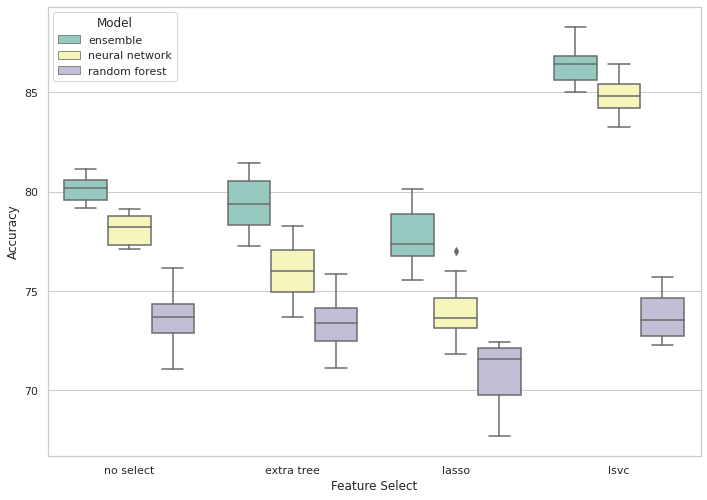

In [11]:
sns.set(style="whitegrid",rc={'figure.figsize':(11.7,8.27)})
sns.set(style="whitegrid")
ax = sns.boxplot(x = "Feature Select", y = "Accuracy", hue="Model", data = df, palette = "Set3")